In [2]:
import control

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
num = np.array([8])
den = np.array([1, 1.6, 4])

Gs = control.tf(num, den)
Gs

TransferFunction(array([8]), array([1. , 1.6, 4. ]))

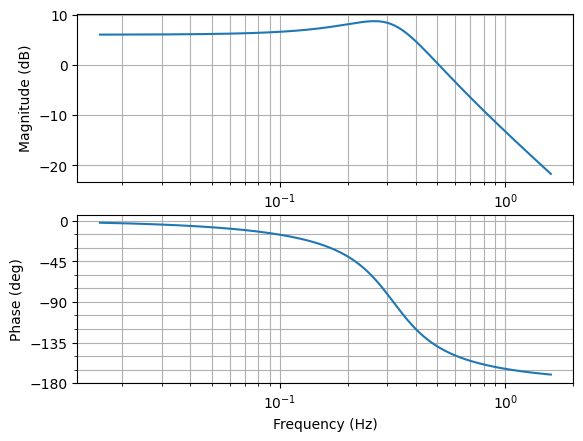

In [5]:
# Bode diagram
control.bode(Gs, dB=True, Hz=True, omega_limits=(0.1, 10), plot=True);

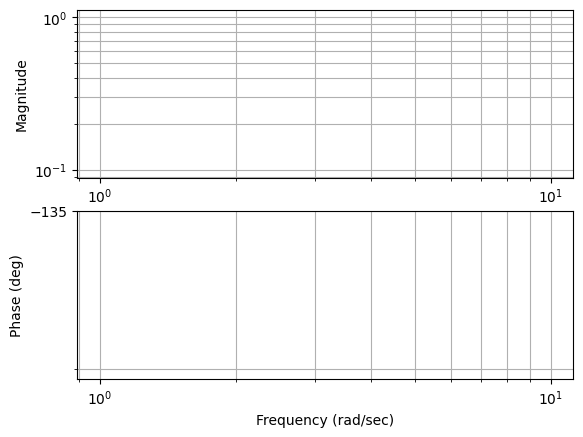

In [6]:
m = control.bode(Gs, omega=3.333)

In [7]:
m

(array([0.90021244]), array([-2.49798953]), array([3.333]))

In [8]:
m[1] * 180 / 3.14159265

array([-143.1242574])

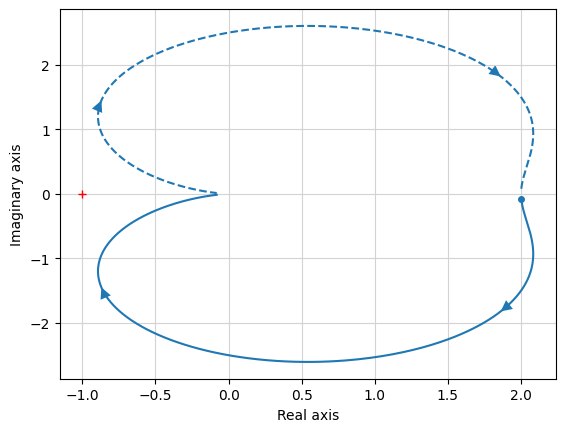

In [9]:
# Nyquist diagram
control.nyquist(Gs, omega_limits=(0.1, 10), plot=True);

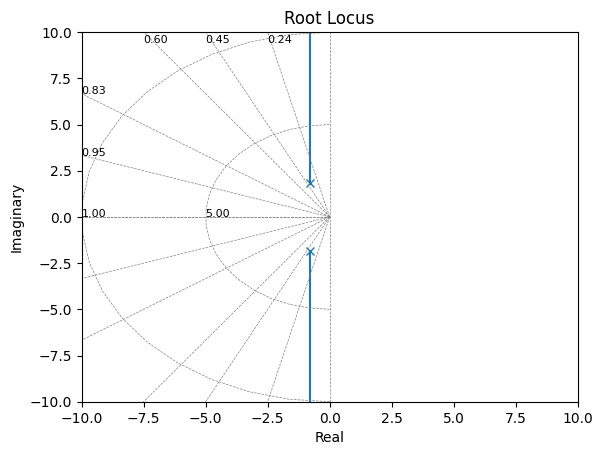

In [10]:
# Root locus
control.rlocus(Gs, kvect=np.linspace(0, 10, 1000), xlim=(-10, 10), ylim=(-10, 10), plot=True);

In [11]:
# Margin gain and phase
'''
    gm (float) – Gain margin

    pm (float) – Phase margin (in degrees)

    wcg (float or array_like) – Crossover frequency associated with gain margin (phase crossover frequency), where phase crosses below -180 degrees.

    wcp (float or array_like) – Crossover frequency associated with phase margin (gain crossover frequency), where gain crosses below 1.
'''

gm, pm, wcg, wcp = control.margin(Gs)
print('Margem de ganho: ', gm)
print('Margem de fase: ', str(pm) + ' graus')
print('Frequência associada com a margem de ganho: ', str(wcg) + ' Rad/seg')
print('Frequência associada com a margem de fase: ', str(wcp) + ' Rad/seg')

Margem de ganho:  inf
Margem de fase:  39.61231058053758 graus
Frequência associada com a margem de ganho:  nan Rad/seg
Frequência associada com a margem de fase:  3.1879476381760603 Rad/seg


Questão 2

O teorema do valor final diz que:

   lim_{t->inf}f(t) = lim_{s->0}sF(s)
   
   onde f(t) é a resposta ao degrau e F(s) é a função de transferência

Para o sistema em questão, temos:

   lim_{t->inf}y(t) = lim_{s->0}sY(s)

   onde y(t) é a resposta ao degrau e Y(s) é a função de transferência

Considerando um controlador PD da forma:

   C(s) = (Kp + Kd*s)E(s)

Temos o seguinte sistema compensado:

   Gc(s) = G(s)C(s) = (Kp + Kds)E(s)*G(s)

   Gc(s) = (Kp + Kds)E(s)8 / (s^2 + 1,6s + 4)

   Pelo teorema do valor final:

   val_final = lim_{s->0}{s(Kp + Kds)E(s)8 / (s^2 + 1,6s + 4)}

   Considerando E(s) = 1/s:

   val_final = lim_{s->0}{(Kp + Kds)8 / (s^2 + 1,6s + 4)} = 8/4 = 2

Portanto com um controlador PD não e possivel zerar o erro em regime permanente, visto que ele não adiciona um polo na origem
   


In [12]:
#PD controller
Kp = 1
Kd = 0.1
C = control.tf([Kd, Kp],[1])
C

TransferFunction(array([0.1, 1. ]), array([1]))

In [13]:
Gc = control.series(C, Gs)
Gc

TransferFunction(array([0.8, 8. ]), array([1. , 1.6, 4. ]))

In [14]:
#Reposta ao degrau
yout, T = control.step_response(Gc)

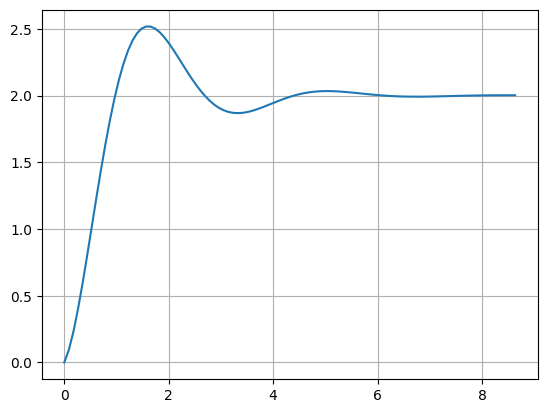

In [15]:
plt.plot(yout,T)
plt.grid()

Considerando o controlador:
    C(s) = a1s + a0 / b1s + 1

    1. Nova frequência de cruzamento de ganho: 2 rad/s

    2. Margem de Fase: 60°

    3. Adote o valor de a0 = 0,8

    Com isso ja temos: 

    C(s) = a1s + 0.8 / b1s + 1

Dados do sistema sem controlador:

Margem de ganho:  inf

Margem de fase:  39.61231058053758 graus

Frequência associada com a margem de ganho:  nan Rad/seg

Frequência associada com a margem de fase:  3.1879476381760603 Rad/seg

In [16]:
a0 = 0.8

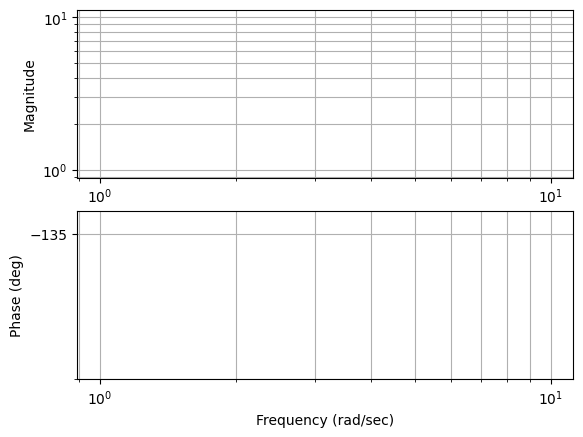

In [17]:
magJW, phase, omega = control.bode(Gs, omega = wcp)

In [45]:
#Temos 
phi = -180 + 60 - (phase * (180 / 3.14159265))
phi

array([20.38768958])

In [36]:
magJW

array([1.])

In [40]:
phase

array([-2.45022741])

In [41]:
from math import pi


SatJW = 1j*phase
SatJW

array([-0.-2.45022741j])

In [42]:
absGsJW = abs(8 / ((SatJW)**2 + 1.6*SatJW +4))
absGsJW

array([1.81706886])

In [46]:
# Calculo do a1

from math import cos, pi, sin


a_1 = (1 - a0*abs(magJW)*cos(phi*(pi/180)))/(phase * (180 / 3.14159265)*absGsJW*sin(phi*(pi/180)))
a_1 = a_1[0]
a_1

-0.002814471841398274

In [47]:
#Calculando b1
b_1 = (cos(phi*(pi/180)) - a0*abs(magJW))/(phase * (180 / 3.14159265)*sin(phi*(pi/180)))
b_1 = b_1[0]
b_1

-0.0028085344996879955

In [24]:
Cav = control.tf([a_1, a0], [b_1, 1])
Cav

TransferFunction(array([-12.59726962,   0.8       ]), array([-0.00280853,  1.        ]))

In [29]:
SisCont = control.series(Gs, Cav)
SisCont

TransferFunction(array([-100.77815696,    6.4       ]), array([-2.80853450e-03,  9.95506345e-01,  1.58876586e+00,  4.00000000e+00]))

In [33]:
yout1, T1 = control.step_response(Cav)

In [30]:
yout1, T1 = control.step_response(SisCont)

/home/JoaoYamashita/.local/lib/python3.10/site-packages/control/timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]


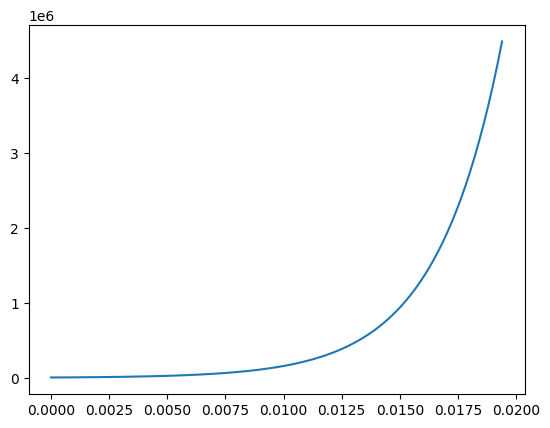

In [34]:
plt.plot(yout1, T1)